In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
#UNET Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/ME19B190-ASS-9/training_set.zip


Archive:  gdrive/My Drive/ME19B190-ASS-9/training_set.zip
   creating: training_set/
 extracting: training_set/100_2HC.png  
  inflating: training_set/100_2HC_Annotation.png  
 extracting: training_set/101_HC.png  
  inflating: training_set/101_HC_Annotation.png  
 extracting: training_set/102_2HC.png  
  inflating: training_set/102_2HC_Annotation.png  
 extracting: training_set/103_HC.png  
  inflating: training_set/103_HC_Annotation.png  
 extracting: training_set/104_HC.png  
  inflating: training_set/104_HC_Annotation.png  
 extracting: training_set/105_HC.png  
  inflating: training_set/105_HC_Annotation.png  
 extracting: training_set/106_HC.png  
  inflating: training_set/106_HC_Annotation.png  
 extracting: training_set/107_HC.png  
  inflating: training_set/107_HC_Annotation.png  
 extracting: training_set/108_2HC.png  
  inflating: training_set/108_2HC_Annotation.png  
 extracting: training_set/109_HC.png  
  inflating: training_set/109_HC_Annotation.png  
 extracting: traini

In [ ]:
!unzip gdrive/My\ Drive/ME19B190-ASS-9/test_set.zip > /dev/null

In [ ]:
import cv2;
import numpy as np;
 
def return_binarymask(img_path):
  im_in = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE); 
  th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
  
  im_floodfill = im_th.copy()
  
  h, w = im_th.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)
  
  cv2.floodFill(im_floodfill, mask, (0,0), 255);
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  
  return np.abs(mask-1)


In [ ]:
x,y = [],[]


In [ ]:
import os
from os import listdir
 
folder_dir = "/content/training_set"
for images in os.listdir(folder_dir):
 
    if (images.endswith("HC.png")):
        x.append(images)
    if (images.endswith("HC_Annotation.png")):
        y.append(images)

In [ ]:
import numpy as np

x = np.array(x)
y = np.array(y)
x.sort()
y.sort()

In [ ]:
import pandas as pd
paths = np.array(list(zip(x,y)))

image_paths = pd.DataFrame(paths,columns = ['Input_path','Output_path'])
print(len(image_paths))
image_paths.head(5)

999


Input_path             Output_path
0  100_2HC.png  100_2HC_Annotation.png
1   101_HC.png   101_HC_Annotation.png
2  102_2HC.png  102_2HC_Annotation.png
3   103_HC.png   103_HC_Annotation.png
4   104_HC.png   104_HC_Annotation.png

In [ ]:
#training and validation datasets
indices = np.random.choice(np.arange(len(image_paths)),round(0.8*len(image_paths)),replace = False)
train_csv   = image_paths.iloc[indices]

valid_indx = list(set(np.arange(len(image_paths))).difference(indices))
valid_csv   = image_paths.iloc[valid_indx]


In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import albumentations as A
from tqdm import tqdm
import torch.optim as optim
from albumentations.pytorch import ToTensorV2


In [ ]:
#creating custom datasets
class fetusdataset(Dataset):
  def __init__(self,image_path,transform):
    self.dataframe = image_path
    self.transform = transform
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, idx):
        train_image = np.array(Image.open("/content/training_set/"+self.dataframe.iloc[idx][0]).convert("L"))
        target_image  = return_binarymask("/content/training_set/"+self.dataframe.iloc[idx][1])
        target_image[target_image == 255.0] = 1.0
        augmentations = self.transform(image=train_image, mask=target_image)
        image = augmentations["image"]
        mask = augmentations["mask"]
        return image, mask  

In [ ]:
class fetusdataset_test(Dataset):
  def __init__(self,image_path,transform):
    self.dataframe = image_path
    self.transform = transform
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, idx):
        test_image = np.array(Image.open("/content/test_set/"+self.dataframe.iloc[idx][0]).convert("L"))
        augmentations = self.transform(image=test_image)
        image = augmentations["image"]
        return image

In [ ]:
#Image transformations
IMAGE_HEIGHT = 200
IMAGE_WIDTH  = 200  
train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )


In [ ]:
temp = fetusdataset(image_paths,train_transform)
train_image,test_image = temp.__getitem__(1)

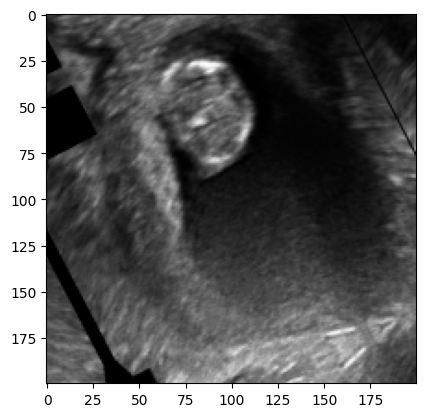

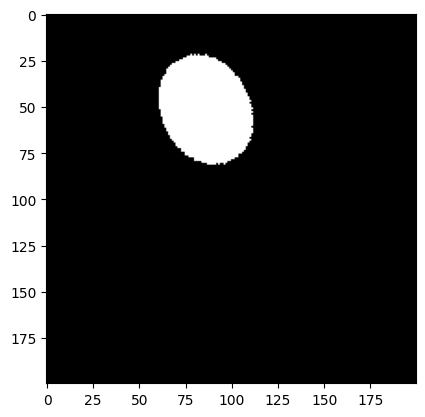

In [ ]:
plt.imshow(train_image.numpy().squeeze(),cmap= 'gray')
plt.show()
plt.imshow(test_image.numpy(),cmap= 'gray')
plt.show()

In [ ]:
batch_size = 5
#instantiating dataset 
#Data loaders

def get_loaders(train_csv,valid_csv,train_transform,val_transform,batch_size):

  train_dataset = fetusdataset(train_csv,train_transform)
  valid_dataset = fetusdataset(valid_csv,val_transform)
  train_loader  = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, num_workers = 0,shuffle = True)
  val_loader  = torch.utils.data.DataLoader(valid_dataset,batch_size = batch_size, num_workers = 0)
  return train_loader,val_loader



In [ ]:
#get_dice_score
def get_dice_score(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    return dice_score/len(loader)


In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler,loss_arr):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(DEVICE)
        targets = targets.float().unsqueeze(1).to(DEVICE)

        
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            loss_arr.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

      
        loop.set_postfix(loss=loss.item())
    return loss_arr

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
model = UNET(in_channels=1, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_loader, val_loader = get_loaders(train_csv,valid_csv,train_transform,val_transform,batch_size)

**U NET Implementation:**

In [ ]:
#train UNET
scaler = torch.cuda.amp.GradScaler()
dice_score_epoch = []
loss_epoch = []
for epoch in range(10):
      loss_epoch = train_fn(train_loader, model, optimizer, loss_fn, scaler,loss_epoch)
      dice_score = get_dice_score(val_loader, model, device=DEVICE)
      dice_score_epoch.append(dice_score)


  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 150/150 [00:28<00:00,  5.21it/s, loss=0.219]


Got 9678240/10000000 with acc 96.78
Dice score: 0.9464355111122131


100%|██████████| 150/150 [00:19<00:00,  7.52it/s, loss=0.138]


Got 9777944/10000000 with acc 97.78
Dice score: 0.9622094631195068


100%|██████████| 150/150 [00:20<00:00,  7.45it/s, loss=0.142]


Got 9784542/10000000 with acc 97.85
Dice score: 0.9637109041213989


100%|██████████| 150/150 [00:20<00:00,  7.20it/s, loss=0.0913]


Got 9772628/10000000 with acc 97.73
Dice score: 0.9609560370445251


100%|██████████| 150/150 [00:20<00:00,  7.18it/s, loss=0.119]


Got 9790857/10000000 with acc 97.91
Dice score: 0.9646948575973511


100%|██████████| 150/150 [00:20<00:00,  7.37it/s, loss=0.135]


Got 9818151/10000000 with acc 98.18
Dice score: 0.9693881273269653


100%|██████████| 150/150 [00:20<00:00,  7.44it/s, loss=0.0665]


Got 9800575/10000000 with acc 98.01
Dice score: 0.9662389159202576


100%|██████████| 150/150 [00:20<00:00,  7.38it/s, loss=0.107]


Got 9809279/10000000 with acc 98.09
Dice score: 0.9683018326759338


100%|██████████| 150/150 [00:21<00:00,  7.09it/s, loss=0.117]


Got 9824367/10000000 with acc 98.24
Dice score: 0.9706884026527405


100%|██████████| 150/150 [00:20<00:00,  7.27it/s, loss=0.0682]


Got 9846607/10000000 with acc 98.47
Dice score: 0.9742743968963623


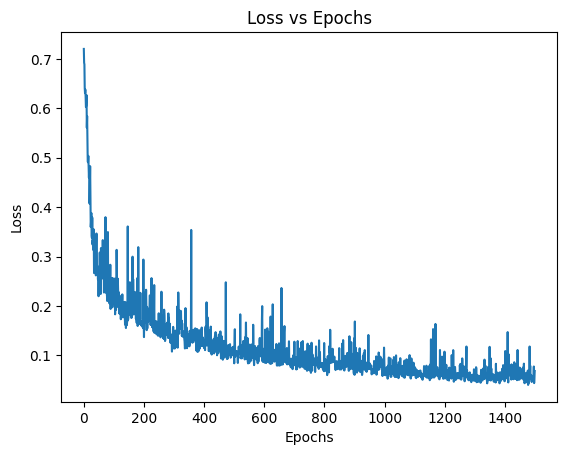

In [ ]:
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_epoch)),loss_epoch)

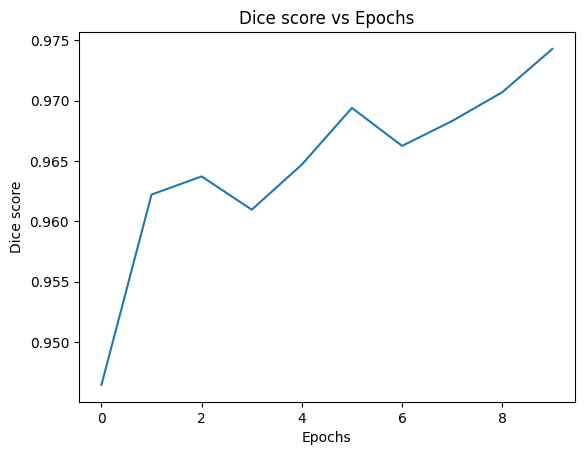

In [ ]:
dice_score_epoch_t = [i.item() for i in dice_score_epoch]
plt.title("Dice score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice score")
plt.plot(np.arange(len(dice_score_epoch)),dice_score_epoch_t)

Custom Encoder- decoder: Implementation

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


#Custom Encoder Decoder
class CustomEncoder(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[30, 60, 120, 240,480]):
        super(CustomEncoder, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=5, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((x, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [ ]:
model_custom = CustomEncoder(in_channels=1, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_custom.parameters(), lr=LEARNING_RATE)

In [ ]:
#Train Custom Encoder Decoder
train_loader, val_loader = get_loaders(train_csv,valid_csv,train_transform,val_transform,batch_size)
scaler = torch.cuda.amp.GradScaler()
dice_score_epoch = []
loss_epoch = []
print("Training for Custom Encoder Decoder")
for epoch in range(20):
      loss_epoch = train_fn(train_loader, model_custom, optimizer, loss_fn, scaler,loss_epoch)
      dice_score = get_dice_score(val_loader, model_custom, device=DEVICE)
      dice_score_epoch.append(dice_score)

Training for Custom Encoder Decoder


100%|██████████| 150/150 [00:16<00:00,  8.88it/s, loss=0.269]


Got 9412806/10000000 with acc 94.13
Dice score: 0.908495306968689


100%|██████████| 150/150 [00:17<00:00,  8.77it/s, loss=0.192]


Got 9718705/10000000 with acc 97.19
Dice score: 0.9516541957855225


100%|██████████| 150/150 [00:16<00:00,  9.04it/s, loss=0.184]


Got 9687711/10000000 with acc 96.88
Dice score: 0.9455353617668152


100%|██████████| 150/150 [00:16<00:00,  8.86it/s, loss=0.144]


Got 9724594/10000000 with acc 97.25
Dice score: 0.9532325267791748


100%|██████████| 150/150 [00:16<00:00,  8.95it/s, loss=0.131]


Got 9756104/10000000 with acc 97.56
Dice score: 0.9590803980827332


100%|██████████| 150/150 [00:16<00:00,  9.02it/s, loss=0.1]


Got 9755602/10000000 with acc 97.56
Dice score: 0.9591884613037109


100%|██████████| 150/150 [00:16<00:00,  8.91it/s, loss=0.113]


Got 9748930/10000000 with acc 97.49
Dice score: 0.9583522081375122


100%|██████████| 150/150 [00:16<00:00,  8.97it/s, loss=0.0774]


Got 9768648/10000000 with acc 97.69
Dice score: 0.9615744352340698


100%|██████████| 150/150 [00:17<00:00,  8.79it/s, loss=0.087]


Got 9785297/10000000 with acc 97.85
Dice score: 0.9626418948173523


100%|██████████| 150/150 [00:16<00:00,  9.04it/s, loss=0.0722]


Got 9768237/10000000 with acc 97.68
Dice score: 0.9612711668014526


100%|██████████| 150/150 [00:16<00:00,  8.96it/s, loss=0.0669]


Got 9798091/10000000 with acc 97.98
Dice score: 0.9656779170036316


100%|██████████| 150/150 [00:16<00:00,  8.97it/s, loss=0.0658]


Got 9822586/10000000 with acc 98.23
Dice score: 0.9703025817871094


100%|██████████| 150/150 [00:16<00:00,  9.01it/s, loss=0.0648]


Got 9824936/10000000 with acc 98.25
Dice score: 0.9703201055526733


100%|██████████| 150/150 [00:17<00:00,  8.73it/s, loss=0.0508]


Got 9801126/10000000 with acc 98.01
Dice score: 0.9660618305206299


100%|██████████| 150/150 [00:16<00:00,  8.96it/s, loss=0.0699]


Got 9819068/10000000 with acc 98.19
Dice score: 0.9686135053634644


100%|██████████| 150/150 [00:16<00:00,  8.93it/s, loss=0.0857]


Got 9808611/10000000 with acc 98.09
Dice score: 0.9670864939689636


100%|██████████| 150/150 [00:16<00:00,  9.00it/s, loss=0.0641]


Got 9819443/10000000 with acc 98.19
Dice score: 0.9693869352340698


100%|██████████| 150/150 [00:16<00:00,  9.00it/s, loss=0.0466]


Got 9824718/10000000 with acc 98.25
Dice score: 0.9698222875595093


100%|██████████| 150/150 [00:17<00:00,  8.80it/s, loss=0.0533]


Got 9839805/10000000 with acc 98.40
Dice score: 0.9732031226158142


100%|██████████| 150/150 [00:16<00:00,  9.01it/s, loss=0.0705]


Got 9760942/10000000 with acc 97.61
Dice score: 0.9589716196060181


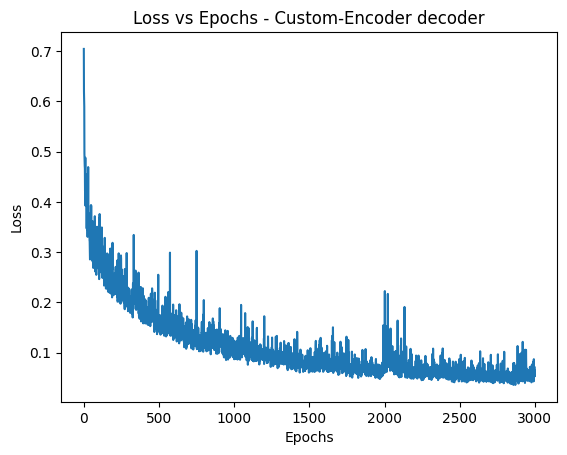

In [ ]:
plt.title("Loss vs Epochs - Custom-Encoder decoder")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_epoch)),loss_epoch)

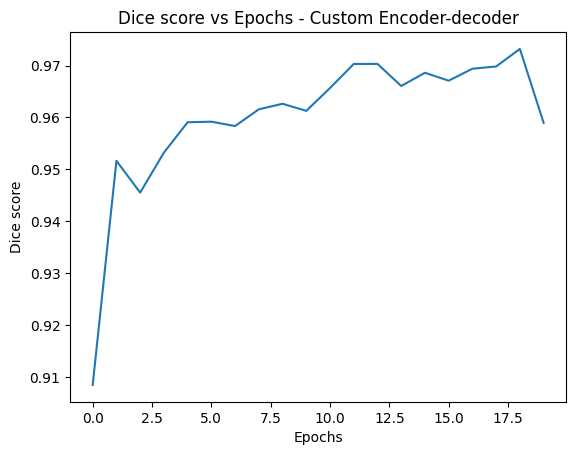

In [ ]:
dice_score_epoch_t = [i.item() for i in dice_score_epoch]
plt.title("Dice score vs Epochs - Custom Encoder-decoder")
plt.xlabel("Epochs")
plt.ylabel("Dice score")
plt.plot(np.arange(len(dice_score_epoch)),dice_score_epoch_t)

In [ ]:
#Function that returns predictions on test data
def return_predictions(img_path,model):
  test_image = np.array(Image.open(img_path).convert("L"))
  augmentations = val_transform(image=test_image)
  image = augmentations["image"].resize(1,1,IMAGE_HEIGHT,IMAGE_WIDTH)
  pred  = model(image.to(DEVICE)).detach().cpu().numpy()
  pred = pred.reshape(IMAGE_HEIGHT,IMAGE_WIDTH)
  pred = torch.sigmoid(torch.from_numpy(pred))
  pred = (pred>0.5).float()
  pred = pred.numpy()
  img = np.uint8(pred) 
  t_lower = 0 # Lower Threshold
  t_upper = 1  # Upper threshold
  edge = np.array(cv2.Canny(img, t_lower, t_upper))
  img1 = image.reshape(IMAGE_HEIGHT,IMAGE_WIDTH).numpy()
  img2 = (cv2.merge([img1,img1,img1]))
  img2[:,:,1][edge>0.5] = 1
  img2[:,:,0][edge>0.5] = 0
  img2[:,:,2][edge>0.5] = 0
  plt.imshow(img2)



In [ ]:
#getting test data set
test_image_path = []
folder_dir = "/content/test_set"
for images in os.listdir(folder_dir):
 
    if (images.endswith("HC.png")):
        test_image_path.append("/content/test_set/"+images)


In [ ]:
pred_images = np.random.choice(test_image_path, 20)


**Return Predictions on Test Dataset with UNET:**

The predictions given below are for 20 images from test data

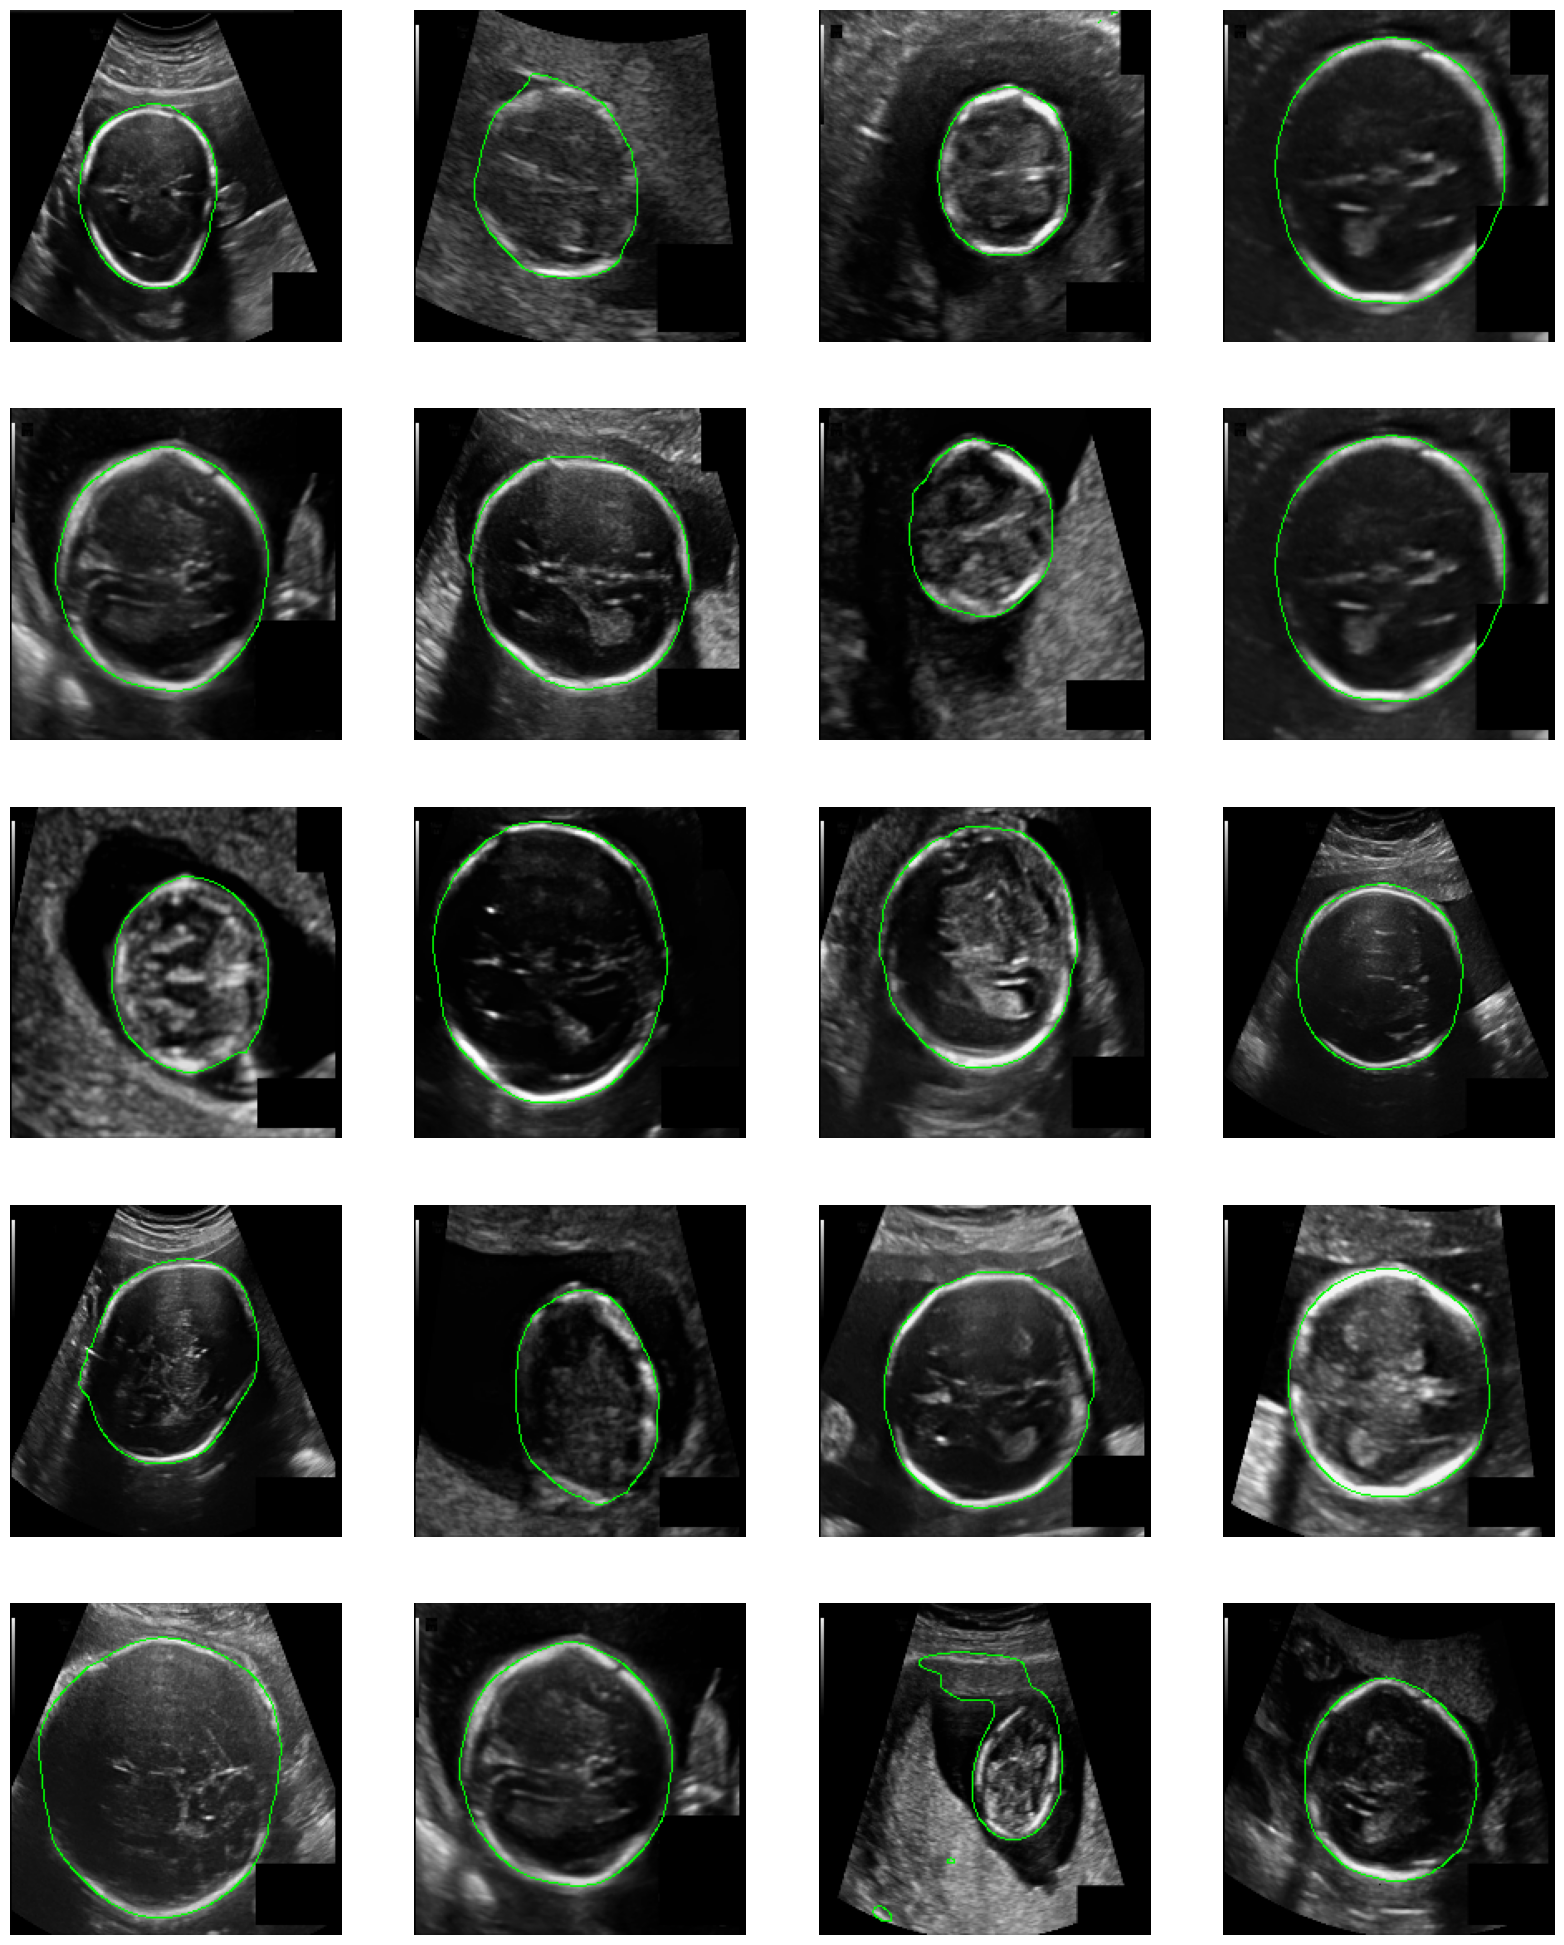

In [ ]:
plt.figure(figsize=(20,25))
k = 1
for path in pred_images:
  plt.subplot(5,4,k)
  plt.axis("off")
  return_predictions(path,model)
  k+=1
plt.show()

**Return Predictions on Test Dataset with Custom Encoder decoder:**

The predictions given below are for 20 images from test data


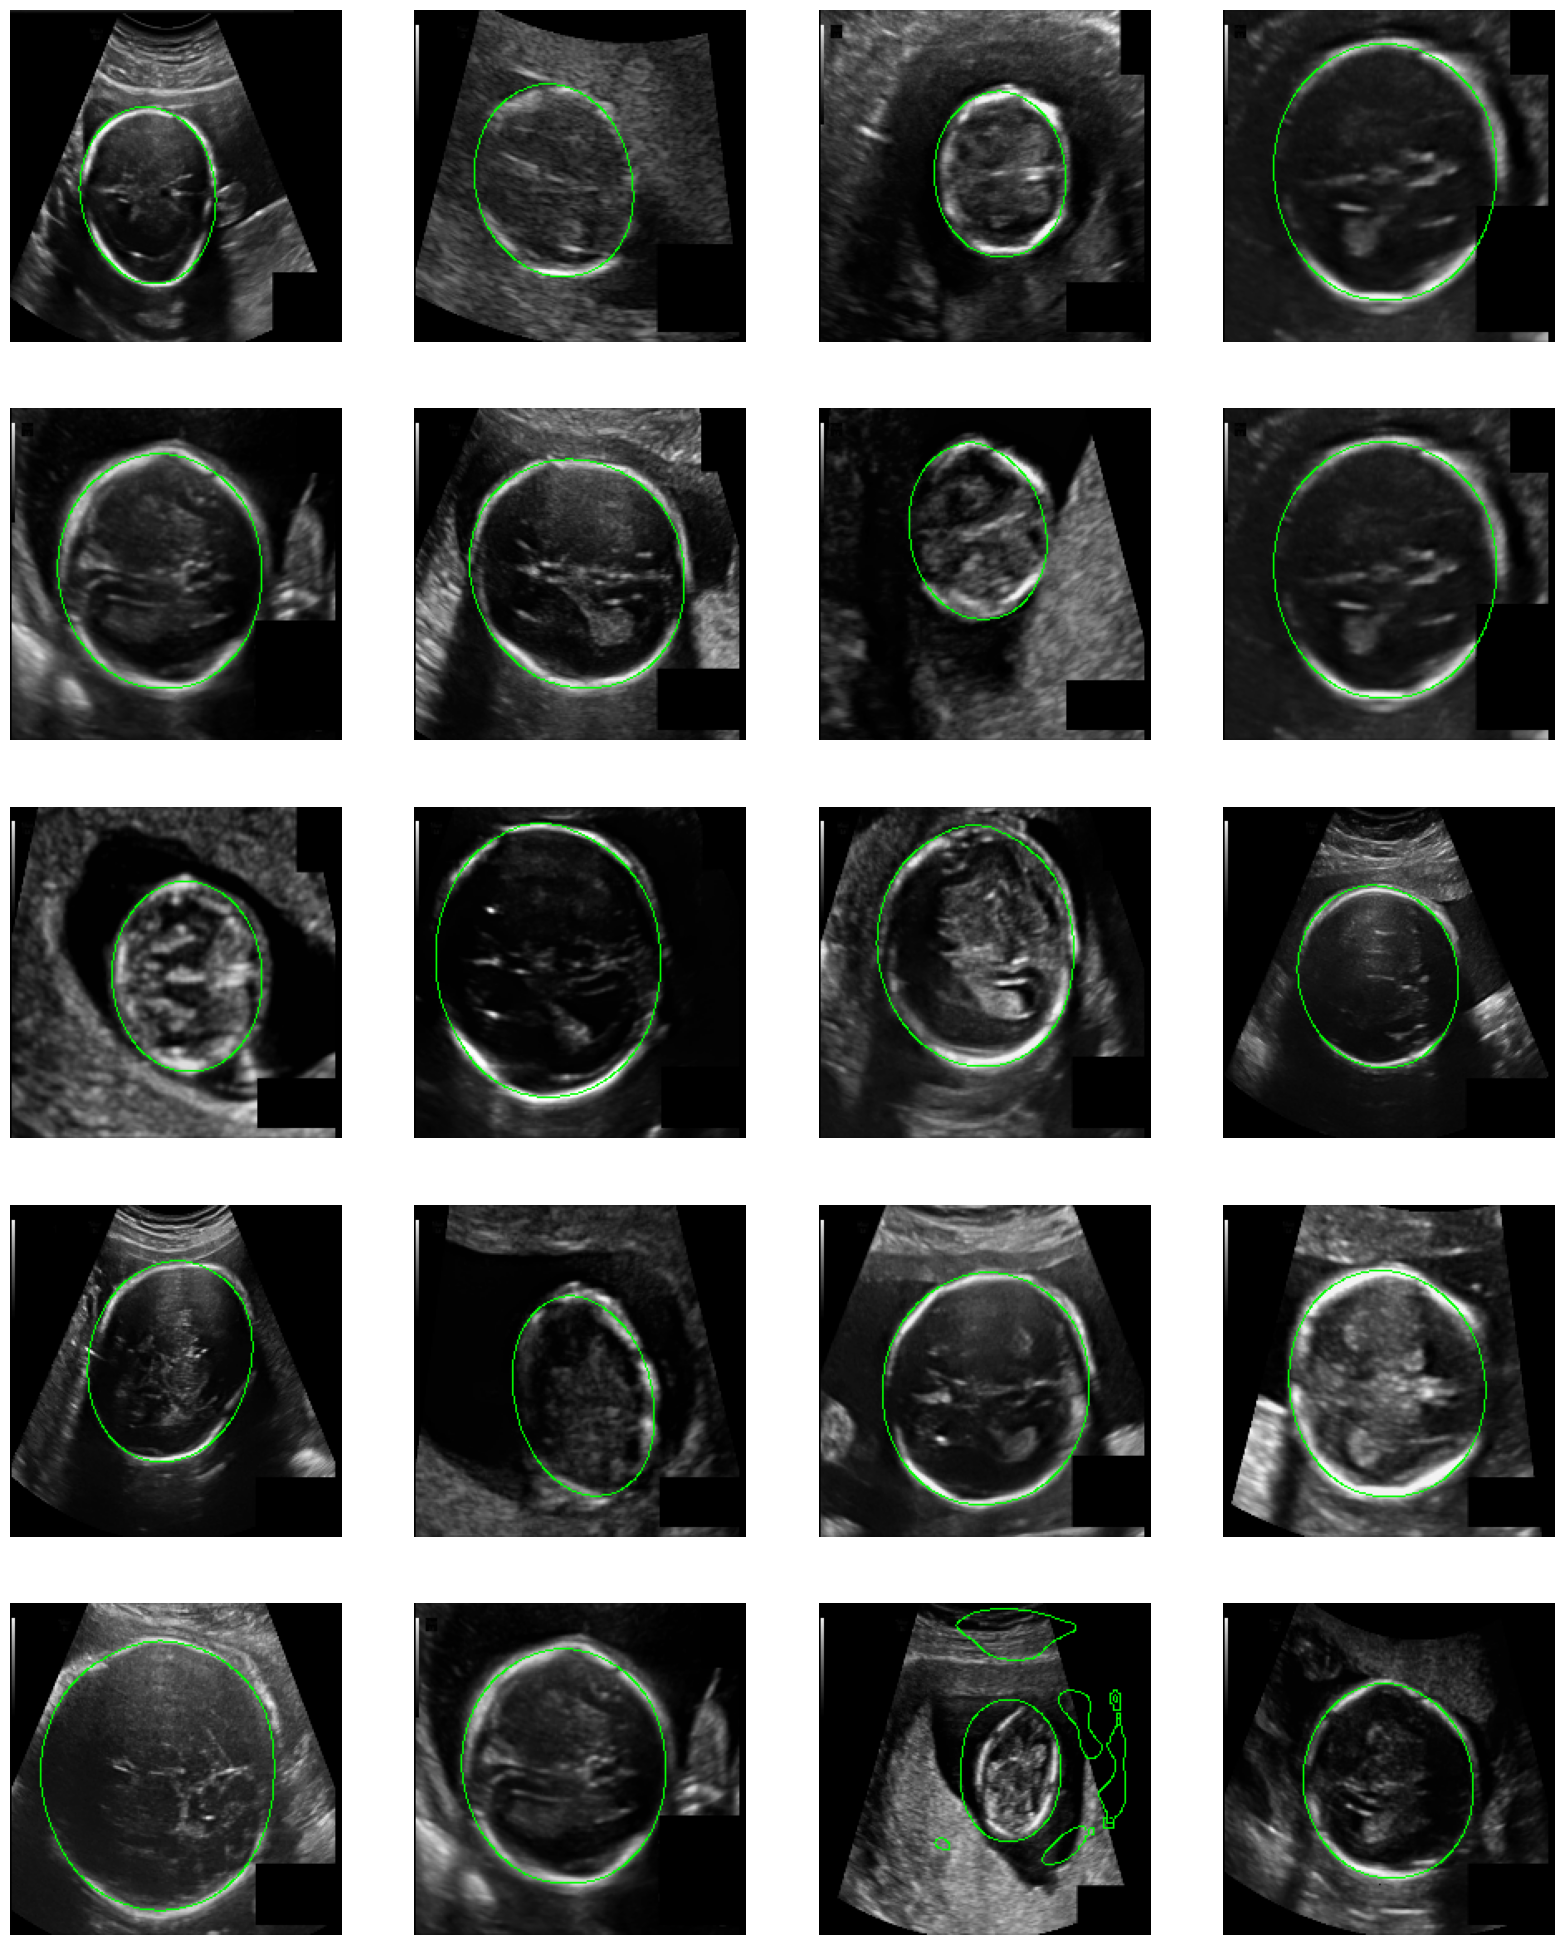

In [ ]:
plt.figure(figsize=(20,25))
k = 1
for path in pred_images:
  plt.subplot(5,4,k)
  plt.axis("off")
  return_predictions(path,model_custom)
  k+=1
plt.show()

**Conclusions**:

1. Dice score of UNET model(0.974) is better than Dice score of Custom Encoder Decoder model(0.9585)
2. From the predicted images, the predictions of Plain UNET model are better than CustomEncoderDecoder model.